In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sci

pd.set_option('float_format', '{:6.3f}'.format)
sns.set(style='ticks')

import warnings
warnings.filterwarnings("ignore")

In [2]:
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,4

In [3]:
df=pd.read_csv('vardata.csv', index_col = [0,1])

In [4]:
df.head()

IPM      EMPM  HOURSM    CPI   WAGE    FFR  STOCK  VOLATBL  \
YEAR MONTH                                                                 
1962 7     25.157 15522.000  40.500 30.220  2.270  2.710 54.750   19.572   
     8     25.211 15517.000  40.500 30.280  2.280  2.930 58.230   15.794   
     9     25.397 15568.000  40.500 30.420  2.280  2.900 59.120   18.315   
     10    25.344 15569.000  40.300 30.380  2.290  2.900 56.270   25.967   
     11    25.557 15530.000  40.500 30.380  2.290  2.940 56.520   16.766   

            CLEAN  FCLEAN  OCLEAN  XCLEAN  
YEAR MONTH                                 
1962 7      0.000   0.000   0.000   0.000  
     8      0.000   0.000   0.000   0.000  
     9      0.000   0.000   0.000   0.000  
     10     1.000   1.000   1.000   0.000  
     11     0.000   0.000   0.000   0.000

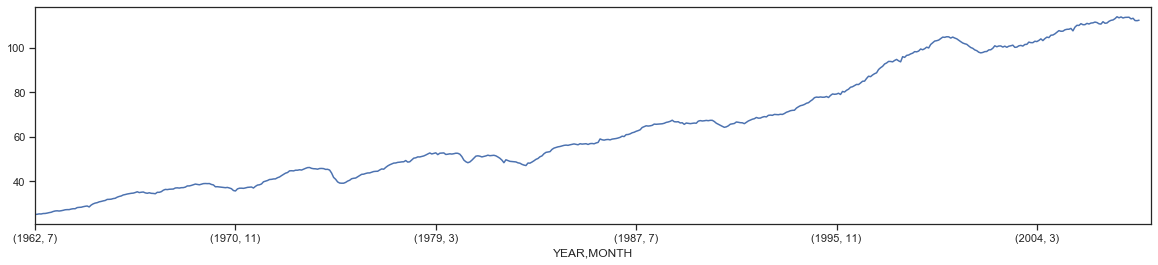

In [5]:
#2
df['IPM'].plot()
plt.show()

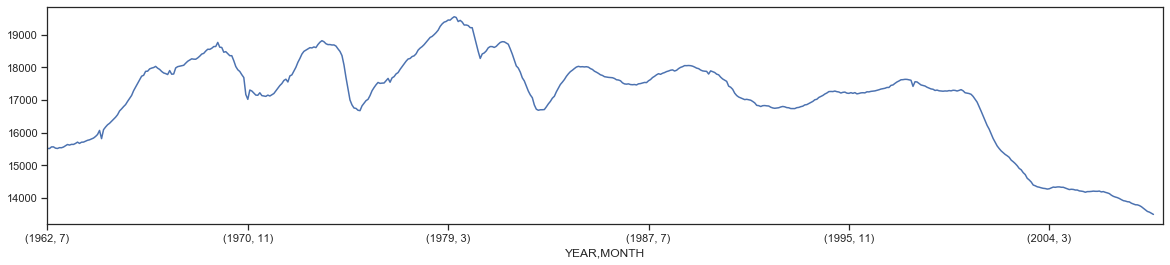

In [6]:
df['EMPM'].plot()
plt.show()

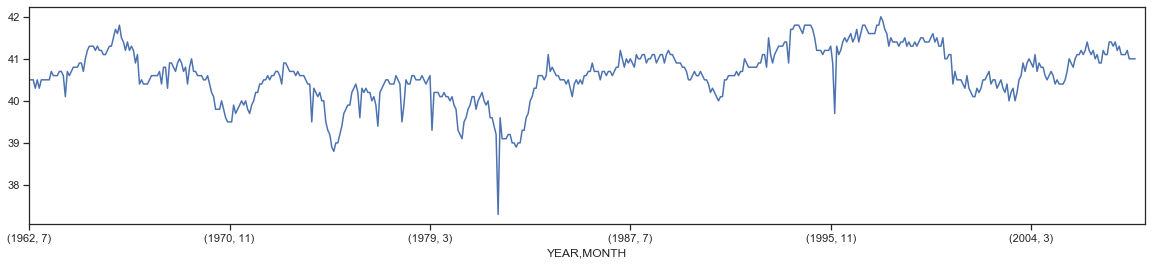

In [7]:
df['HOURSM'].plot()
plt.show()

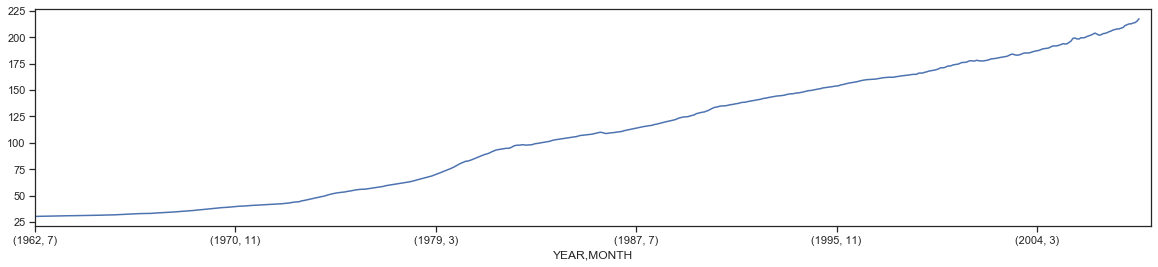

In [8]:
df['CPI'].plot()
plt.show()

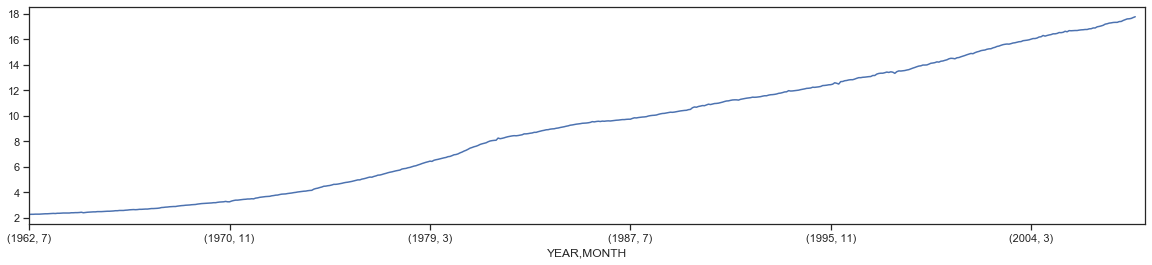

In [9]:
df['WAGE'].plot()
plt.show()

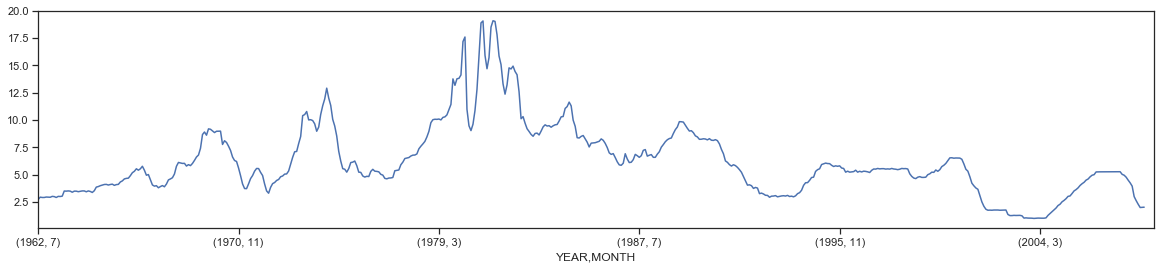

In [10]:
df['FFR'].plot()
plt.show()

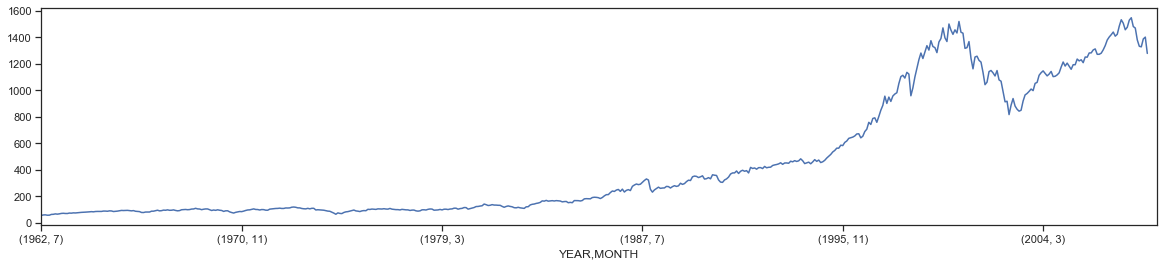

In [11]:
df['STOCK'].plot()
plt.show()

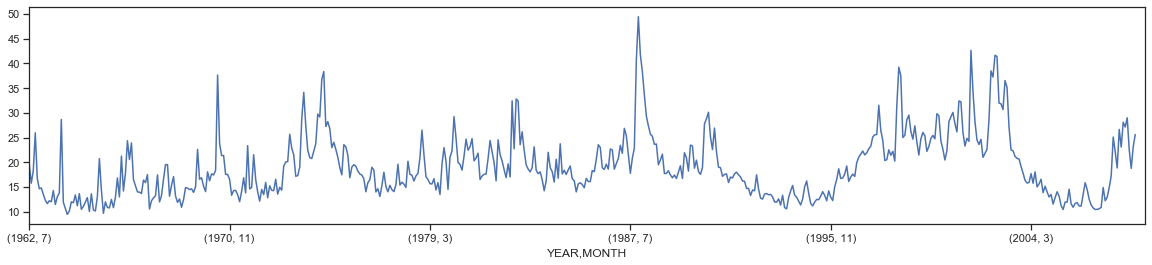

In [12]:
df['VOLATBL'].plot()
plt.show()

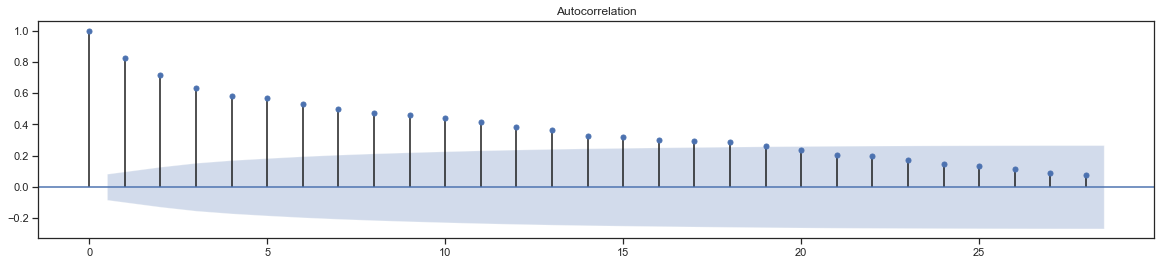

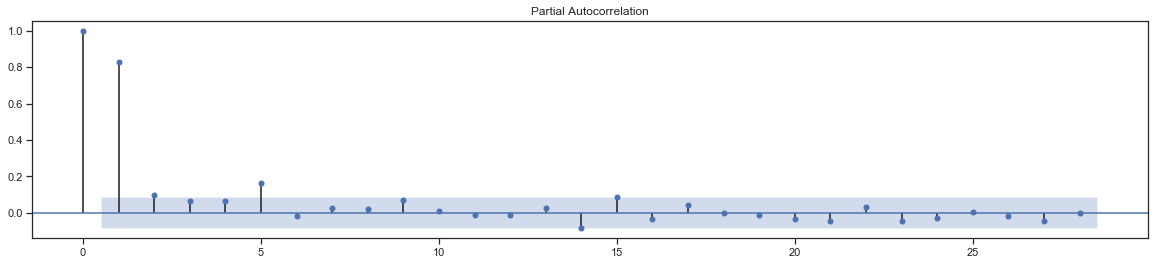

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(df['VOLATBL'].dropna())
plot_pacf(df['VOLATBL'].dropna())
plt.show()

None of these series are stationary. IPM, CPI, stock and wage have explicit trends, the other series have some seosanality , trends or cycles. 

In [14]:
#3
df['LIPM'] = df['IPM'].map(lambda x: np.log(x))
df['LEMPM'] = df['EMPM'].map(lambda x: np.log(x))
df['LCPI'] = df['CPI'].map(lambda x: np.log(x))
df['LWAGE'] = df['WAGE'].map(lambda x: np.log(x))
df['LSTOCK'] = df['STOCK'].map(lambda x: np.log(x))

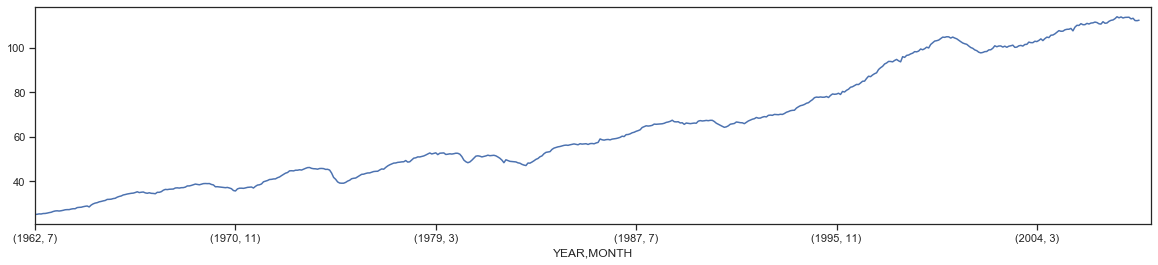

In [15]:
df['IPM'].plot()

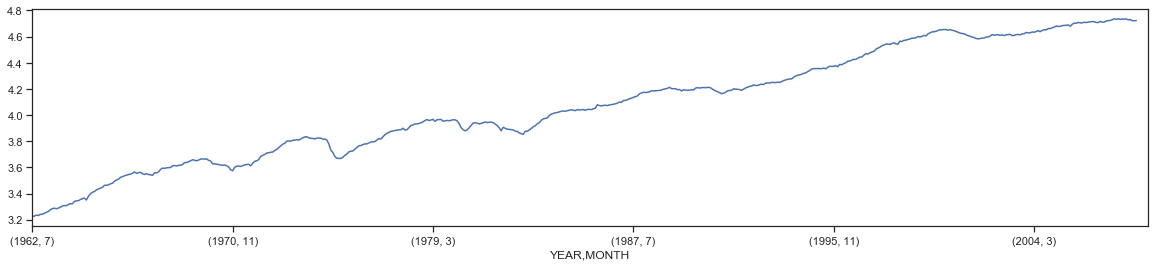

In [16]:
df['LIPM'].plot()

In [17]:
#4
from statsmodels.tsa.filters import hp_filter
df['clipm'] = list(sm.tsa.filters.hpfilter(df['LIPM'].dropna(),lamb = 1600*3**4))[0]
df['choursm'] = list(sm.tsa.filters.hpfilter(df['HOURSM'].dropna(),lamb = 1600*3**4))[0]
df['cffr'] = list(sm.tsa.filters.hpfilter(df['FFR'].dropna(),lamb = 1600*3**4))[0]
df['clempm'] = list(sm.tsa.filters.hpfilter(df['LEMPM'].dropna(),lamb = 1600*3**4))[0]
df['clcpi'] = list(sm.tsa.filters.hpfilter(df['LCPI'].dropna(),lamb = 1600*3**4))[0]
df['clwage'] = list(sm.tsa.filters.hpfilter(df['LWAGE'].dropna(),lamb = 1600*3**4))[0]
df['clstock'] = list(sm.tsa.filters.hpfilter(df['LSTOCK'].dropna(),lamb = 1600*3**4))[0]

In [18]:
sm.tsa.filters.hpfilter(df['LIPM'].dropna(),lamb = 1600*3**4)[1].head()

YEAR  MONTH
1962  7        3.224
      8        3.230
      9        3.236
      10       3.243
      11       3.249
Name: LIPM, dtype: float64

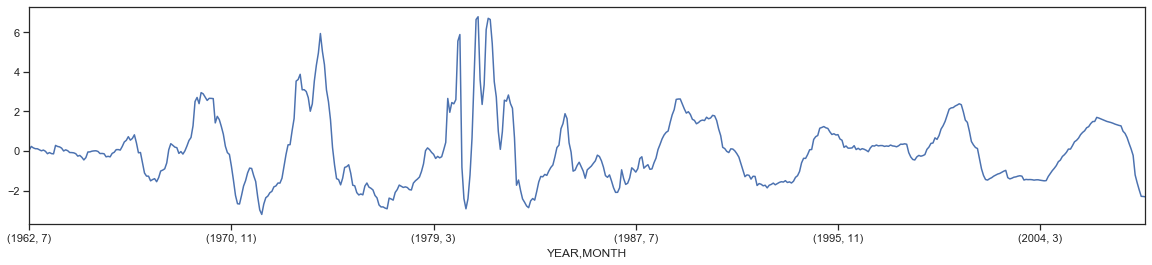

In [19]:
sm.tsa.filters.hpfilter(df['FFR'].dropna(),lamb = 1600*3**4)[0].plot()

#5
There is some order on influencing the stock market index. It starts with instantenous shocks (volatility), then prices (wages, the consumer price index (CPI) and interest rates), and finally quantities (hours, employment, and output). 
He uses 12 lags in his model probably because the information criteria (AIC,BIC) was better than others. 

In [20]:
#6
from statsmodels.tsa.api import VAR
model = VAR(df[['clstock','CLEAN','cffr','clwage','clcpi','choursm','clempm','clipm']].dropna())
results = model.fit(12)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Feb, 2020
Time:                     16:05:28
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -54.2691
Nobs:                     540.000    HQIC:                  -58.0243
Log likelihood:           10964.0    FPE:                5.84210e-27
AIC:                     -60.4362    Det(Omega_mle):     1.55813e-27
--------------------------------------------------------------------
Results for equation clstock
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.001311         0.002249           -0.583           0.560
L1.clstock          0.880624         0.049543           17.775           0.000
L1.CLEAN           -0.025933         0.011825           -2.193    

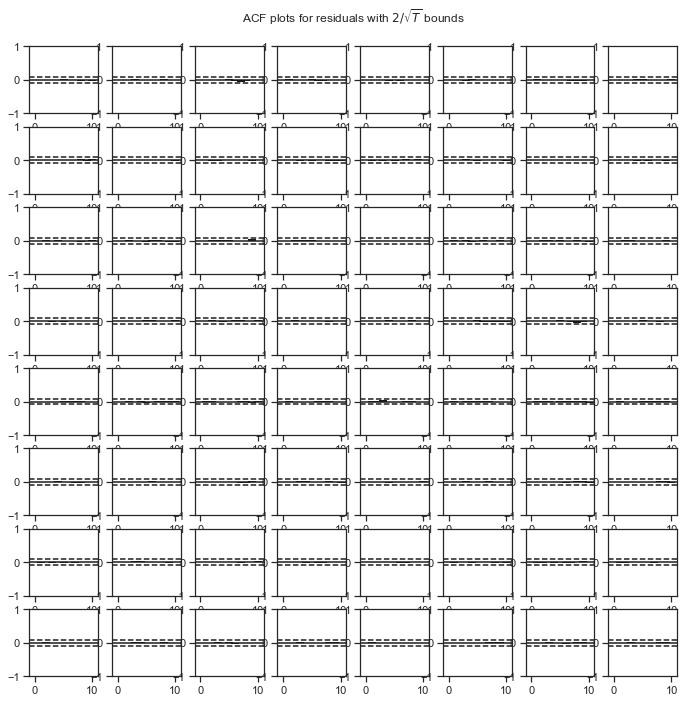

In [21]:
results.plot_acorr(10)
plt.show()

We can see there is no correlation between the cross errors and the errors with itself (I mean when we take errors from a particular equation and then plot acf for the same error but with lags like corr(Ut,Ut-1) corr(Ut,Ut-2) etc.). Hence, the residuals are a white noise process. 

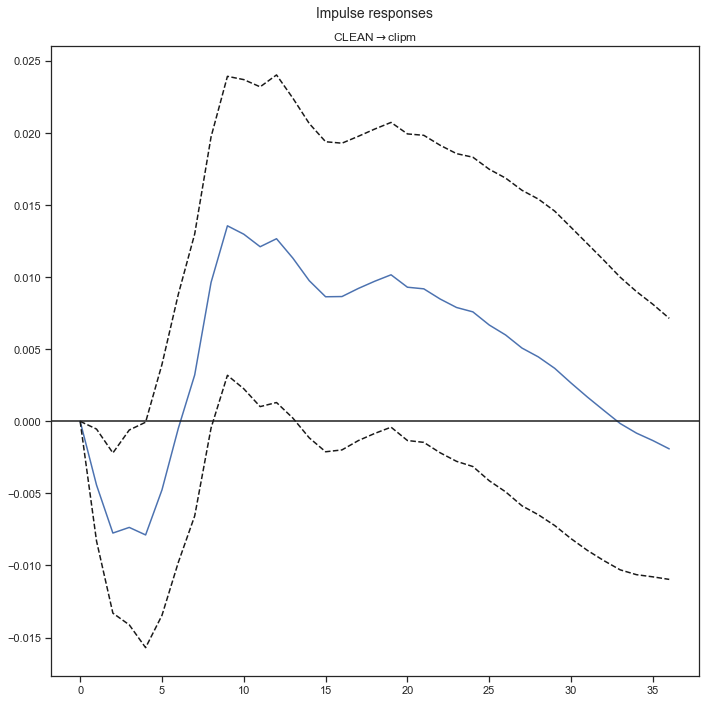

In [53]:
#7
irf = results.irf(36)
irf.plot(impulse='CLEAN', response = 'clipm')
plt.show()

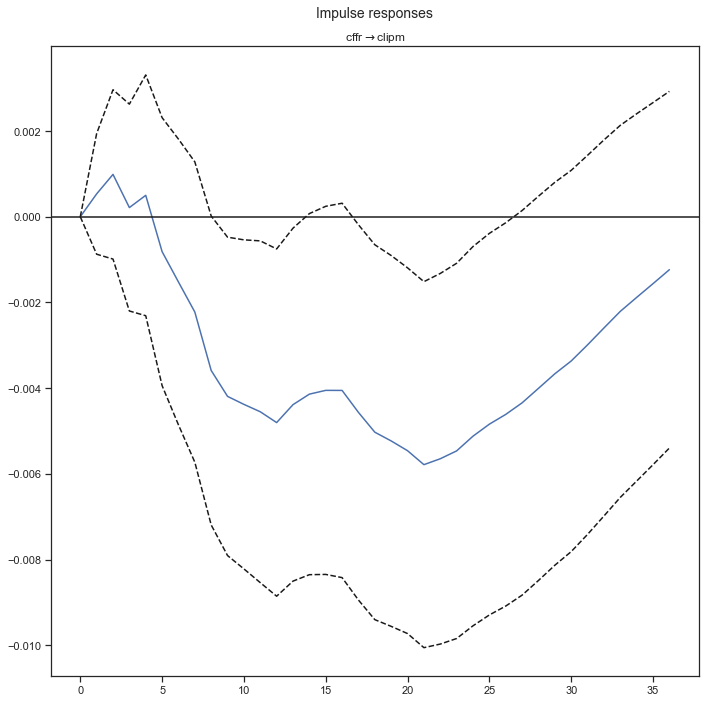

In [52]:
irf.plot(impulse='cffr',response ='clipm')
plt.show()

these IRF are similar to those that are in the article.

In [24]:
#8
for param in range(1,13):
    try:
        model_var = VAR(df[['clstock','CLEAN','cffr','clwage','clcpi','choursm','clempm','clipm']].dropna())
        results_var = model_var.fit(param)
        print(param,results_var.aic,results_var.bic)
    except:
        continue

1 -60.679858404115144 -60.116437521612404
2 -61.117830750295106 -60.05210550331545
3 -61.06389913741368 -59.49446436819345
4 -61.04769447837398 -58.97313850072019
5 -60.96047804242277 -58.3793825996542
6 -60.87718171269312 -57.788121935235246
7 -60.7609003686214 -57.16244473125178
8 -60.66960932968138 -56.56031960842203
9 -60.59988241982082 -55.97831364847383
10 -60.55157924761871 -55.416279673941794
11 -60.49390149855144 -54.843412540069565
12 -60.436231537012674 -54.2690877364622


In [25]:
model_var_2 = VAR(df[['clstock','CLEAN','cffr','clwage','clcpi','choursm','clempm','clipm']].dropna())
results_var_2 = model_var_2.fit(2)
results_var_2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Feb, 2020
Time:                     16:05:42
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -60.0521
Nobs:                     550.000    HQIC:                  -60.7014
Log likelihood:           10700.1    FPE:                2.86373e-27
AIC:                     -61.1178    Det(Omega_mle):     2.24475e-27
--------------------------------------------------------------------
Results for equation clstock
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000517         0.001752            0.295           0.768
L1.clstock         0.897124         0.044925           19.970           0.000
L1.CLEAN          -0.022531         0.010454           -2.155         

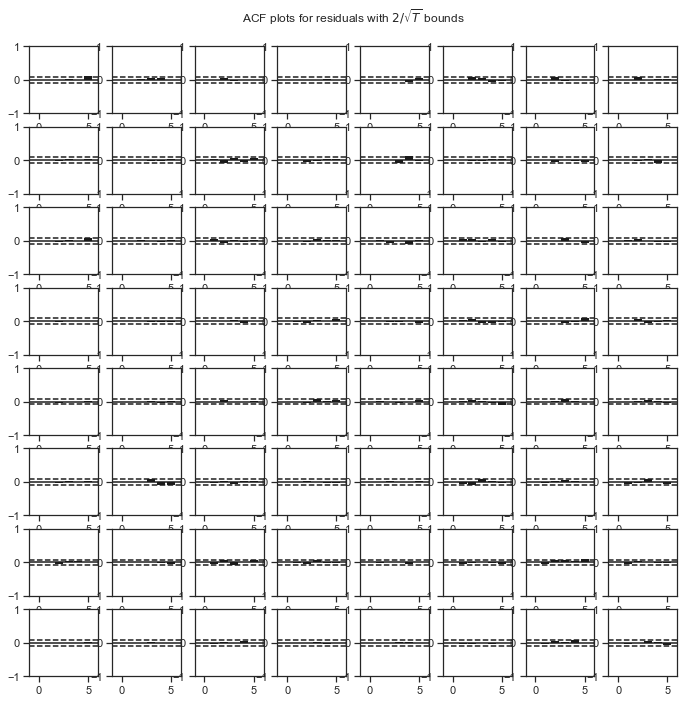

In [26]:
results_var_2.plot_acorr(5)
plt.show()

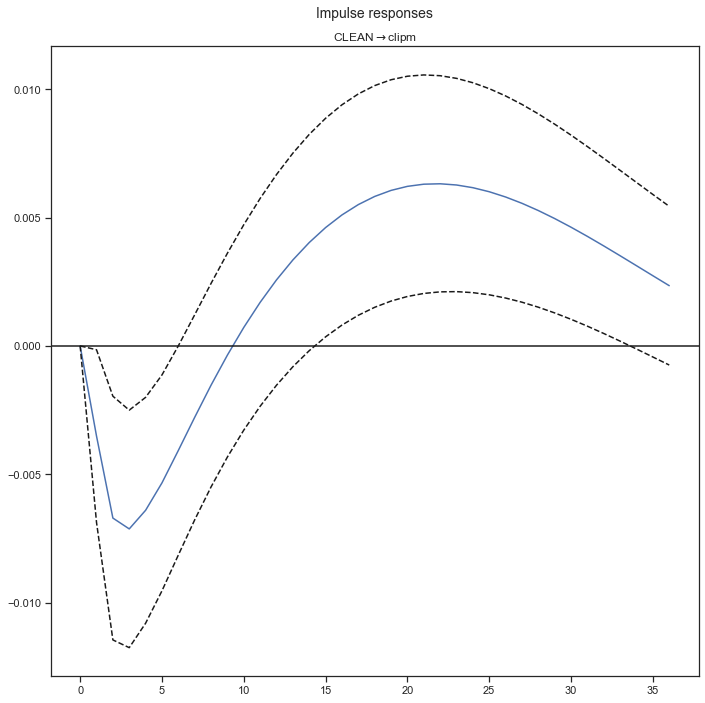

In [82]:
irf_2 = results_var_2.irf(36)
irf_2.plot(impulse='CLEAN', response = 'clipm')
plt.show()

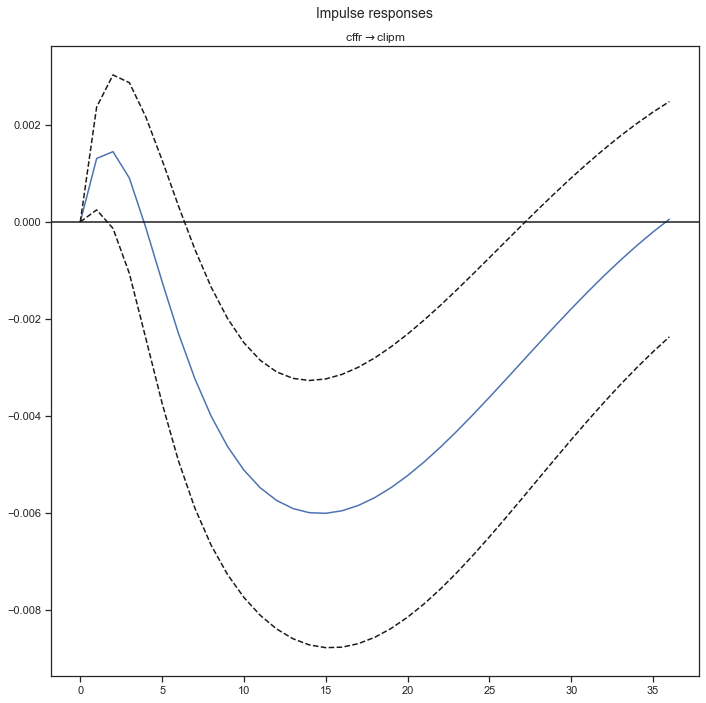

In [83]:
irf_2.plot(impulse='cffr', response = 'clipm')
plt.show()

It is not necessary to use in the model twelve lags because according to the information criteria, the model with two lags is better. The residuals are still a white noise process. We may see some differences in the IPF plots relatively to the paper. the functions are more smooth and a little less impact of shocks. but it still looks the same. 

In [57]:
#9
df['DLSTOCK'] = np.log(df['STOCK']).diff(1)
df['RCPI'] = np.log(df['CPI']).diff(1)

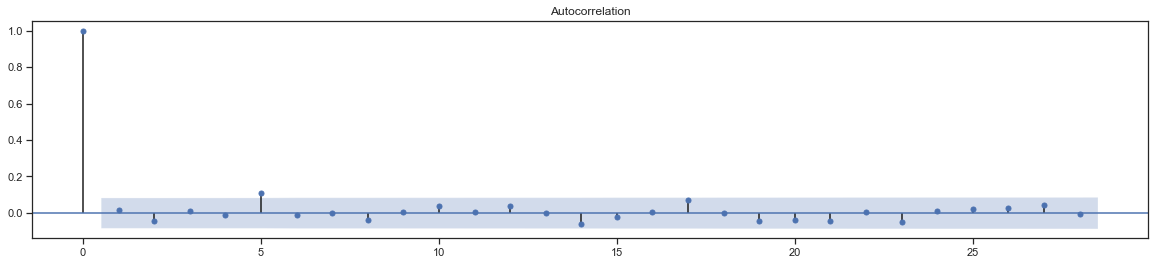

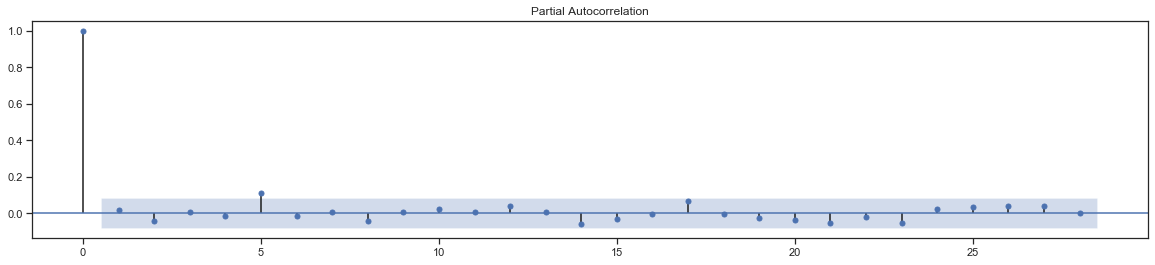

In [80]:
plot_acf(df['DLSTOCK'].dropna())
plot_pacf(df['DLSTOCK'].dropna())
plt.show()

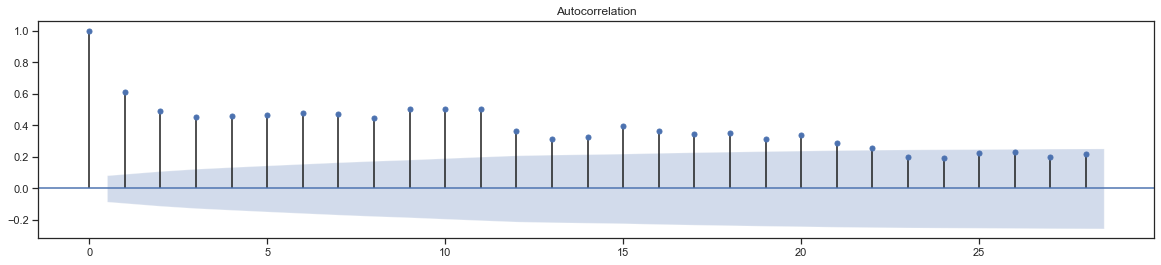

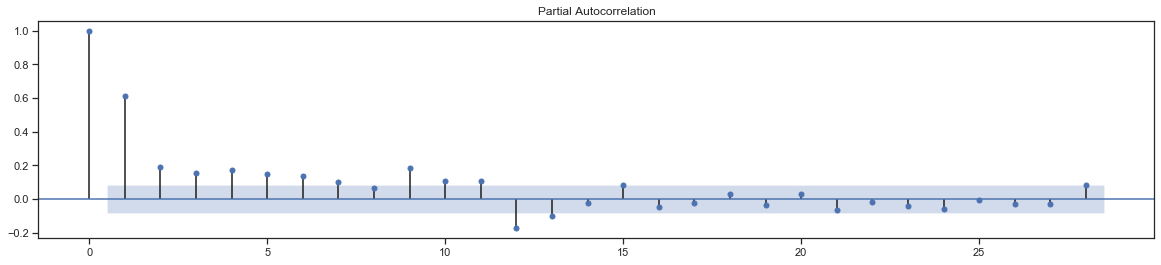

In [81]:
plot_acf(df['RCPI'].dropna())
plot_pacf(df['RCPI'].dropna())
plt.show()

After detrending the series look stationary 

In [68]:
for param in range(0,13):
    try:
        model_var = VAR(df[['DLSTOCK','CLEAN','cffr','clwage','RCPI','choursm','clempm','clipm']].dropna())
        results_var = model_var.fit(param)
        print(param,results_var.aic,results_var.bic)
    except:
        continue

0 -50.20538061439771 -50.14277829411963
1 -60.21810547740842 -59.653897993713315
2 -60.63266218648436 -59.56544654341461
3 -60.70109773153938 -59.12946441513499
4 -60.68895159680254 -58.61148453311076
5 -60.637938137203115 -58.05321464994244
6 -60.58128773404799 -57.487878501923234
7 -60.46414496636099 -56.86061398002587
8 -60.38107862550812 -56.26598314417175
9 -60.35564852492484 -55.72753903259872
10 -60.28767554840422 -55.145095709785885
11 -60.25994234176612 -54.60142895775589
12 -60.20503778388611 -54.02912074673327


In [72]:
model_var_10 = VAR(df[['DLSTOCK','CLEAN','cffr','clwage','RCPI','choursm','clempm','clipm']].dropna())
results_var_10 = model_var_10.fit(3)
print(results_var_10.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Feb, 2020
Time:                     17:01:15
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -59.1295
Nobs:                     548.000    HQIC:                  -60.0868
Log likelihood:           10611.5    FPE:                4.34579e-27
AIC:                     -60.7011    Det(Omega_mle):     3.04142e-27
--------------------------------------------------------------------
Results for equation DLSTOCK
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.010014         0.003430            2.920           0.004
L1.DLSTOCK        -0.034632         0.045767           -0.757           0.449
L1.CLEAN          -0.015694         0.010845           -1.447         

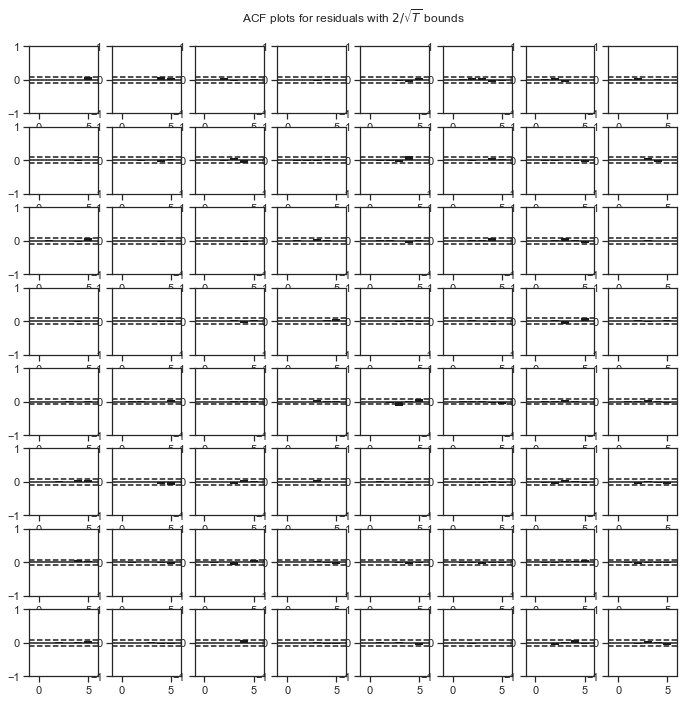

In [73]:
results_var_10.plot_acorr(5)
plt.show()

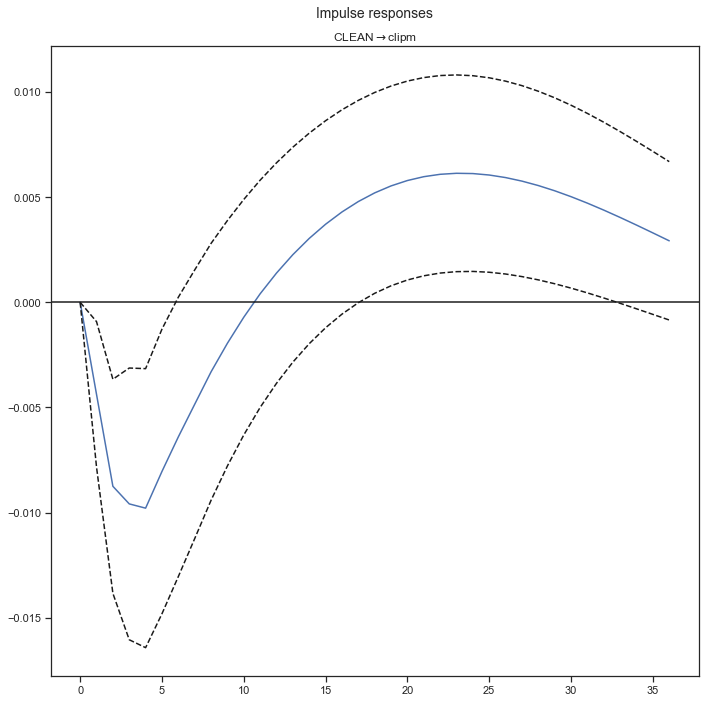

In [74]:
irf_10 = results_var_10.irf(36)
irf_10.plot(impulse='CLEAN', response = 'clipm')
plt.show()

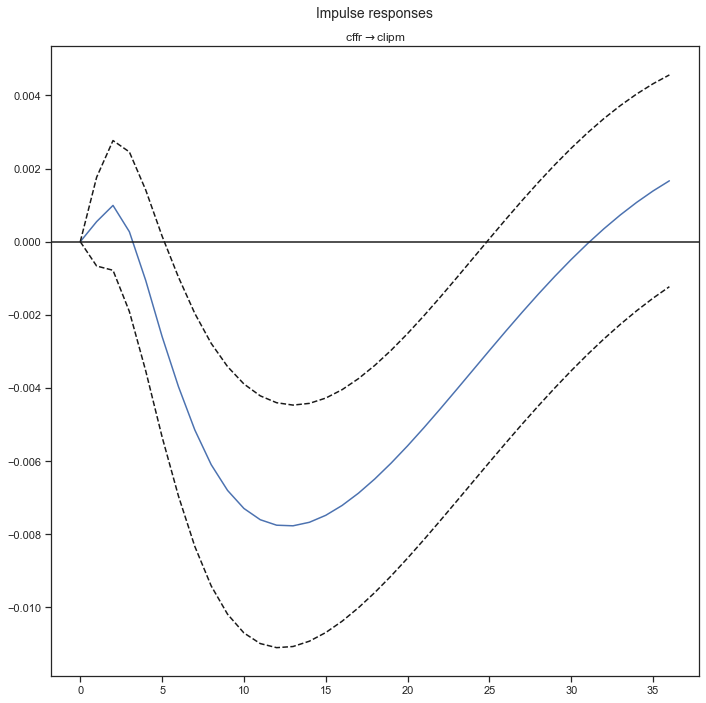

In [76]:
irf_10.plot(impulse='cffr', response = 'clipm')
plt.show()

I chose the best number of lags (3) for this model with the new series, according to the information criteria. The residuals look as a white noise process, the correlation between lags and the cross correlation are practically in the condfidence interval. The result did not change substantionally after changing the way of detrending. IRF are similar to the model with 2 lags. two IRF still look smooth.